# Making a spectrometer GUI
The GUI needs to have the following properties
1. Loads everything from a single setup file (ideally even the `interact` call is defined in the other file
1. Able to initialize any relevant variables
1. Writing in/prompting for whether to save, directory, and filename
1. Can start and stop run with the click of a button
1. Integrates liveplots?

Build stop into the running plots? Or interrupt and then use button to stop ongoing measurements?

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../../../pyscan-master/')

import pyscan as ps
import matplotlib.pyplot as plt
import numpy as np
import utility as ut
from time import sleep
from datetime import date, datetime
from pathlib import Path
from cwsweep_gui import *
from cwsweep_scripts import *
if 'inst' not in globals():
    inst = ps.ItemAttribute()
    devices = ps.ItemAttribute()
    sig = ps.ItemAttribute()
    expt = ps.Sweep(ps.RunInfo(), devices)

plt.rc('lines', lw=2)
plotfont = {'family': 'serif', 'size': 16}
plt.rc('font', **plotfont)
plt.rc('mathtext', fontset='cm')

wait = 0.05

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
controls, output, parameters = cwsweep_gui(sig, inst, devices, expt)
controls

<Figure size 288x288 with 0 Axes>

ValueError: operands could not be broadcast together with shapes (0,) (875,) 

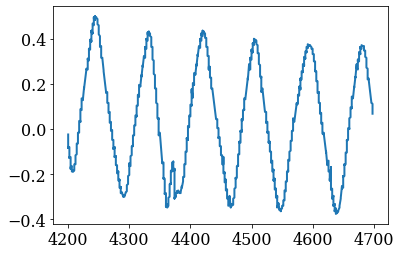

In [3]:
plt.plot(sig.freq, sig.i)

/Research/Acquisition/pyscan-master/notebooks/collett_spectrometer/utility.py:526: RuntimeWarning: invalid value encountered in double_scalars
  return [fit, np.abs(fit[3] / fit[2])]


[array([0., 0., 0., 0.]), nan]

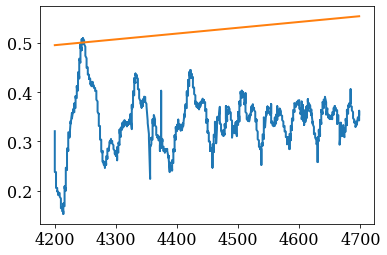

In [4]:
ut.plot_lor_fit(np.array([sig.freq, sig.x]), full=0)

In [28]:
def freqscope():
    ch1 = devices.scope.measure_freq_sweep(parameters, init=False)
    ch2 = devices.scope.measure_freq_sweep(parameters, channel=2, init=False)
    sig = v_to_s(ch1, ch2)
    return sig.freq, sig.x

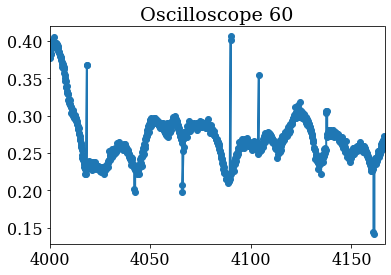

In [15]:
ps.oscilloscope(freqscope, histo_range=1, dt=0.01)

[ 3.23473632e-01  9.36596415e-02  9.20339700e+00  6.05316570e+03
  1.33881499e-01 -2.35508856e+02  6.19437457e+03 -4.62276248e-04]
Q1 is 657.7099414050041 and Q2 is -26.302087693046243


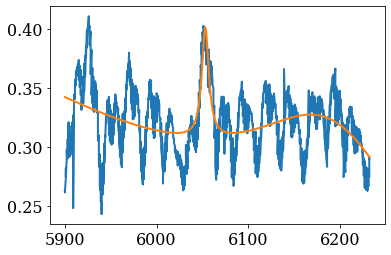

In [26]:
tfit = ut.PlotDoublelor_fit_range(np.array([sig.freq, sig.x]), sig.freq[0], sig.freq[-1])
print(tfit)
print(f'Q1 is {tfit[3]/tfit[2]} and Q2 is {tfit[6]/tfit[5]}')

[array([-3.19956457e-01, -6.73281694e-02,  6.83460003e+00,  5.93442865e+03]),
 868.2920177201484]

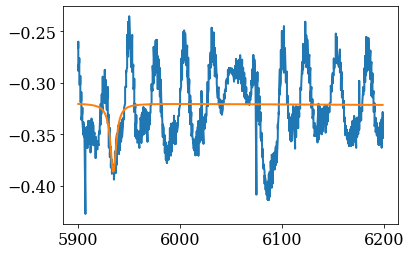

In [30]:
ut.plot_lor_fit(np.array([sig.freq, -sig.x]), full=1)

In [14]:
?ut.plot_lor_fit

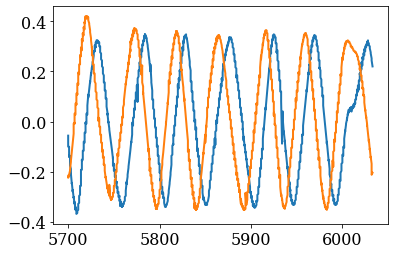

In [28]:
ch1 = devices.scope.measure_freq_sweep(parameters)
ch2 = devices.scope.measure_freq_sweep(parameters, channel=2)
plt.plot(ch1[0], ch1[1], ch2[0], ch2[1]);
# sigon = v_to_s(ch1, ch2)
# plt.plot(sigon.freq, sigon.x);

In [81]:
times = []
Qs = []
Qs2 = []
fs = []
start = datetime.now().timestamp()

In [82]:
def read_Q():
    time = datetime.now().timestamp()
    dt = (time-start)/60
    ch1 = devices.scope.measure_freq_sweep(parameters, init=False)
    ch2 = devices.scope.measure_freq_sweep(parameters, channel=2, init=False)
    sig = v_to_s(ch1, ch2)
    guess = [.02, -.03, 20, 3512]
#     fit = ut.lor_fit(np.array([sig.freq, sig.q]), guess)[0]
    fitsig = np.array([sig.freq, -sig.x])
    try:
        fit = ut.lor_fit(fitsig, guess, full=0)[0]
    except ValueError:
        fit = ut.lor_fit(fitsig, guess, full=0)[0]
    Q = np.abs(fit[-1]/fit[-2]) if fit[-2] != 0 else Qs[-1]
    f = fit[-1]
    times.append(time)
    fs.append(f)
    Qs.append(Q)
#     save_temp(times, temps)
    
#     return [[time, time], [temp, setpoint]]
    return dt, [Q, f]

In [83]:
def read_2Q():
    time = datetime.now().timestamp()
    dt = (time-start)/60
    ch1 = devices.scope.measure_freq_sweep(parameters, init=False)
    ch2 = devices.scope.measure_freq_sweep(parameters, channel=2, init=False)
    sig = v_to_s(ch1, ch2)
    guess = [.02, -.01, 10, 4000]
    try:
        fit = ut.Doublelor_fit_range(np.array([sig.freq, sig.x]), sig.freq[0], sig.freq[-1])[0]
    except ValueError:
        fit = ut.Doublelor_fit_range(np.array([sig.freq, sig.x]), sig.freq[0], sig.freq[-1])[0]
    Q1 = np.abs(fit[3]/fit[2])
    Q2 = np.abs(fit[6]/fit[5])
    times.append(time)
    Qs.append(Q1)
    Qs2.append(Q2)
#     save_temp(times, temps)
    
#     return [[time, time], [temp, setpoint]]
    return dt, Q1#, Q2

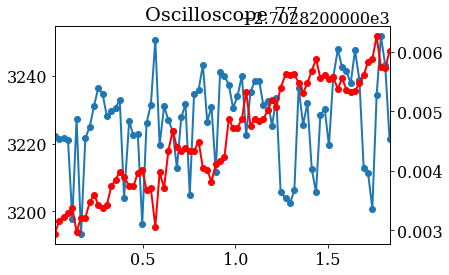

In [84]:
ps.oscilloscope(read_Q, np.inf, 0.1, numy=2)

## Measure and Save
Run this set of cells to set up, measure, and save a frequency sweep

In [22]:
def measure_freq_sweep(expt):
     
    runinfo = expt.runinfo
    devices = expt.devices
    
    if runinfo.initialize:
        initialize_freq_sweep(runinfo.params, devices)
        sleep(2)
    
    d = ps.ItemAttribute()
    
    d.freq, d.volt1 = devices.scope.measure_freq_sweep(runinfo.params, channel=1, init=False)
    _, d.volt2 = devices.scope.measure_freq_sweep(runinfo.params, channel=2, init=False)
    d.x = np.sqrt(d.volt1**2 + d.volt2**2)
    d.p = np.arccos((d.volt1**2 - d.volt2**2) / (d.volt1**2 + d.volt2**2)) / 2
    d.fit = ut.lor_fit(np.array([d.freq, d.x]))[0]
    d.Q = np.abs(d.fit[3]/d.fit[2])
    
    return d

In [122]:
runinfo = ps.RunInfo()
runinfo.loop0 = ps.RepeatScan(100, dt=0.1)

runinfo.initialize = False # Set to False to leave the FPGA and Scope settings as is

runinfo.params = parameters
runinfo.measure_function = measure_freq_sweep

# This is the only important difference
expt = ps.Sweep(runinfo, devices)#, data_dir)
expt.start_thread()

## Stopping the sweep
When you are done with your experiments, you should turn the output off, by running the following cell. You should also turn off the power supply, if it is on.

In [1]:
devices.synth.freq_sweep_stop()

NameError: name 'devices' is not defined